# 1.0 EDA

>### 1.1 Read the data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

df = pd.read_csv("/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv") 

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


In [6]:
print(df.describe())

       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000


In [7]:
print(df['Gender'].value_counts())

Gender
Female    112
Male       88
Name: count, dtype: int64


>### 1.2 Labeling

In [8]:
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

>### 1.3 Apply scaling

In [15]:
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2.0 KMeans Clustering

>### 2.1 Selecting optimal k in KMeans clustering

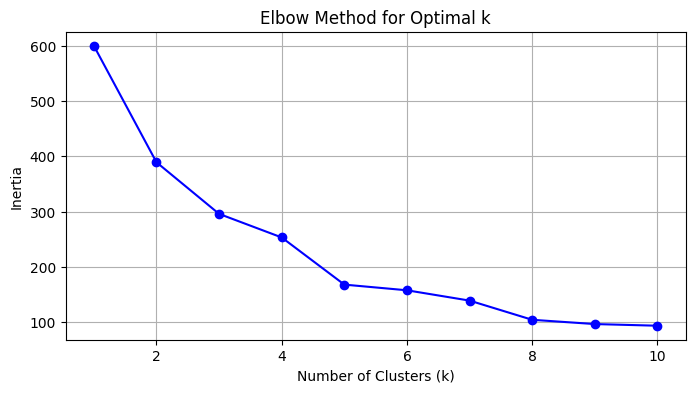

In [16]:
inertia = []
K = range(1, 11)
for k in K:
    model = KMeans(n_clusters=k, random_state=42, n_init='auto')
    model.fit(X_scaled)
    inertia.append(model.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()

> * ### Clearly 5 is the optimal k (at the elbow)

>### 2.2 Apply KMeans clustering with k = 5 :

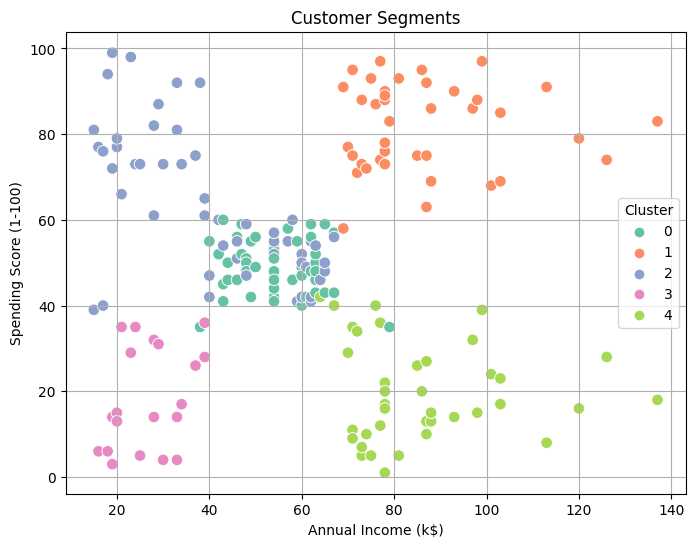

📊 Cluster Summary:
               Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                       
0        55.638298           54.382979               48.851064
1        32.875000           86.100000               81.525000
2        25.185185           41.092593               62.240741
3        46.250000           26.750000               18.350000
4        39.871795           86.102564               19.358974


In [14]:
k_opt = 5
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init='auto')
df['Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='Cluster', palette='Set2', s=70)
plt.title("Customer Segments")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

cluster_summary = df.groupby('Cluster')[features].mean()
print(" Cluster Summary:")
print(cluster_summary)


>### 2.3 Apply KMeans clustering with k = 5 (without scaling) :

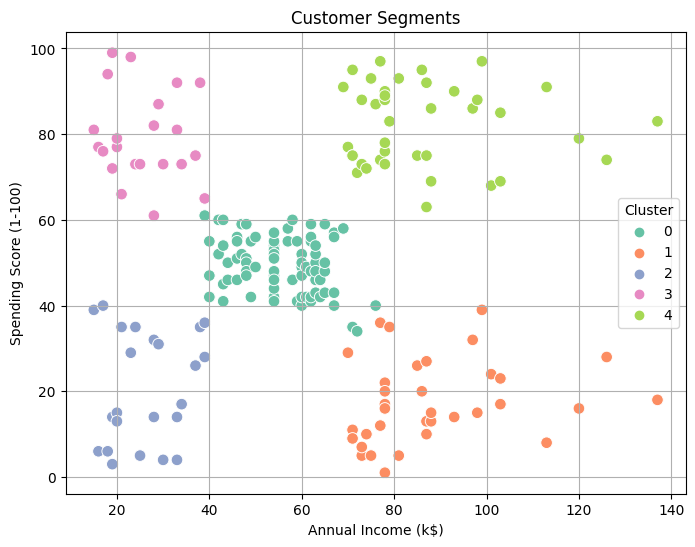

 Cluster Summary:
               Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                       
0        42.716049           55.296296               49.518519
1        41.114286           88.200000               17.114286
2        45.217391           26.304348               20.913043
3        25.272727           25.727273               79.363636
4        32.692308           86.538462               82.128205


In [53]:
k_opt = 5
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(X)
df['Cluster'] = kmeans_labels

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='Cluster', palette='Set2', s=70)
plt.title("Customer Segments")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

cluster_summary = df.groupby('Cluster')[features].mean()
print(" Cluster Summary:")
print(cluster_summary)

>### The second plot (with no scaling) is way better the the first plot (with scaling). but why is that ?
>### In the second plot (no scaling):
>* #### K-Means operates on the true scale of the data.
>
>* #### "Annual Income" has more spread than "Spending Score", so it influences clustering more heavily.
>
>* #### This appears to match the natural groupings in the data.
>
>* #### Thus, the clusters are more interpretable, forming clear, box-like regions in income-vs-spending space.
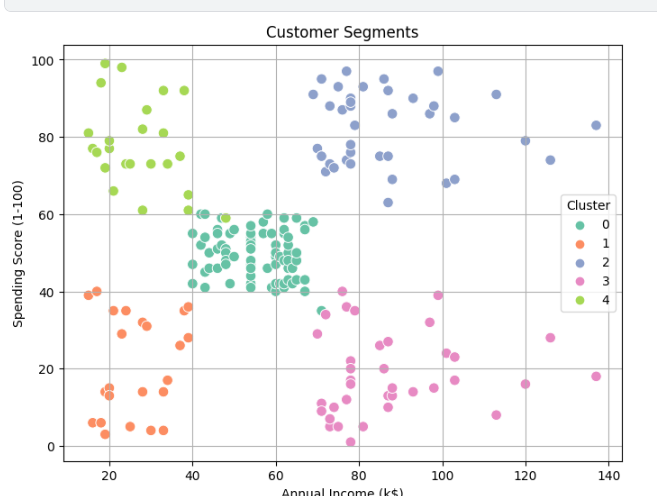
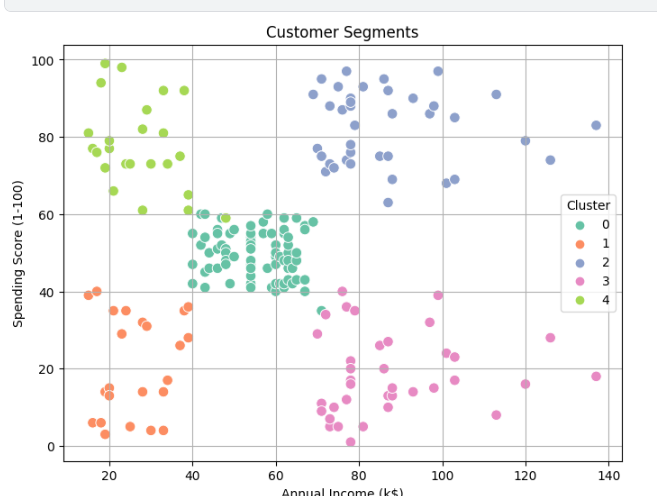

>  ### 2.4 Using Silhouette Score (the higher the better) : 

In [54]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X, kmeans_labels)
print(f"DBSCAN Silhouette Score: {score:.3f}")

DBSCAN Silhouette Score: 0.554


>  ### 2.5 Analyzing averge spending per cluster:

📊 Cluster Summary:

         Avg Spending Score  Avg Income (k$)  Customer Count
Cluster                                                     
2                 82.128205        86.538462              39
3                 79.363636        25.727273              22
1                 49.518519        55.296296              81
4                 20.913043        26.304348              23
0                 17.114286        88.200000              35


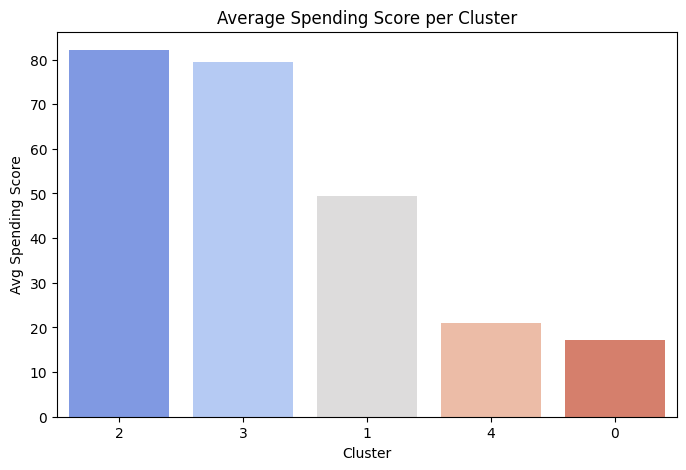

In [56]:
df['Cluster'] = kmeans_labels 

# 2. Group by cluster and compute statistics
cluster_summary = df.groupby('Cluster').agg({
    'Spending Score (1-100)': 'mean',
    'Annual Income (k$)': 'mean',
    'CustomerID': 'count' 
}).rename(columns={
    'Spending Score (1-100)': 'Avg Spending Score',
    'Annual Income (k$)': 'Avg Income (k$)',
    'CustomerID': 'Customer Count'
}).sort_values(by='Avg Spending Score', ascending=False)

print("📊 Cluster Summary:\n")
print(cluster_summary)

plt.figure(figsize=(8, 5))
sns.barplot(
    x=cluster_summary.index.astype(str),
    y=cluster_summary['Avg Spending Score'],
    palette='coolwarm'
)
plt.title("Average Spending Score per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Avg Spending Score")
plt.show()


# 3.0 DBSCAN Clustering (Bouns)

In [19]:
from sklearn.cluster import DBSCAN

X = df[['Annual Income (k$)', 'Spending Score (1-100)']].values

>### 3.1 Let's find the best eps using the elbow method

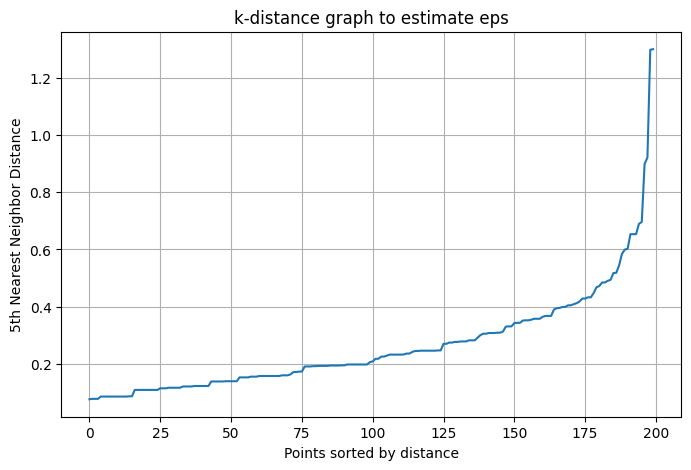

In [39]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, 4]) 
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.ylabel("5th Nearest Neighbor Distance")
plt.xlabel("Points sorted by distance")
plt.title("k-distance graph to estimate eps")
plt.grid(True)
plt.show()

> * ### eps = 0.35 Approx 

>### 3.2 Applying DBSCAN with eps = 0.35

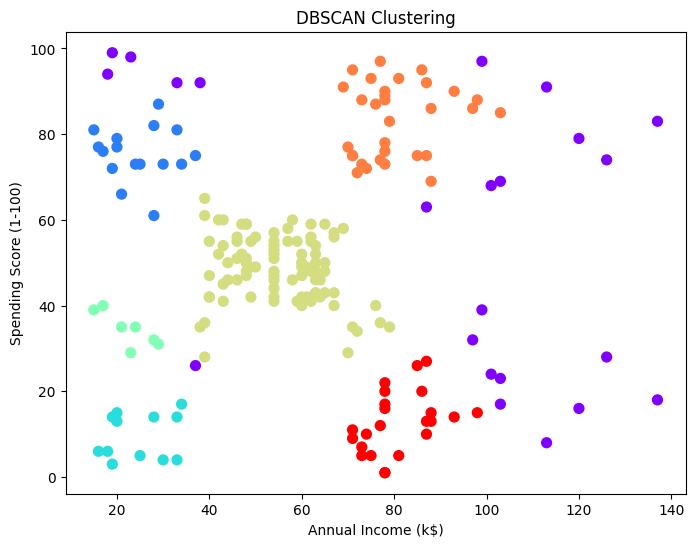

In [51]:
db = DBSCAN(eps=0.35, min_samples=5)  
db_labels = db.fit_predict(X_scaled)    

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='rainbow', s=50)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('DBSCAN Clustering')
plt.show()


>  ### 3.3 Using Silhouette Score (the higher the better) : 

In [47]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X, db_labels)
print(f"DBSCAN Silhouette Score: {score:.3f}")

DBSCAN Silhouette Score: 0.436


>  ### 3.4 Analyzing averge spending per cluster:

📊 Cluster Summary:

         Avg Spending Score  Avg Income (k$)  Customer Count
Cluster                                                     
 4                83.193548        80.290323              31
 0                75.375000        24.750000              16
-1                57.826087        89.260870              23
 3                48.579545        55.227273              88
 2                34.428571        22.428571               7
 5                12.782609        80.956522              23
 1                 9.583333        24.583333              12


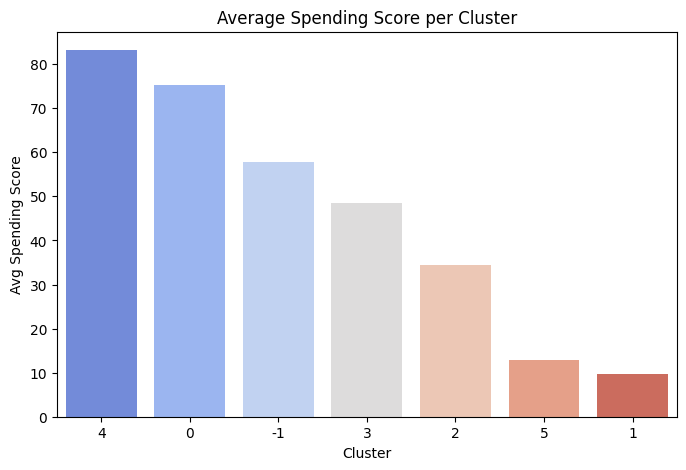

In [52]:
df['Cluster'] = db_labels 

# 2. Group by cluster and compute statistics
cluster_summary = df.groupby('Cluster').agg({
    'Spending Score (1-100)': 'mean',
    'Annual Income (k$)': 'mean',
    'CustomerID': 'count' 
}).rename(columns={
    'Spending Score (1-100)': 'Avg Spending Score',
    'Annual Income (k$)': 'Avg Income (k$)',
    'CustomerID': 'Customer Count'
}).sort_values(by='Avg Spending Score', ascending=False)

print("📊 Cluster Summary:\n")
print(cluster_summary)

plt.figure(figsize=(8, 5))
sns.barplot(
    x=cluster_summary.index.astype(str),
    y=cluster_summary['Avg Spending Score'],
    palette='coolwarm'
)
plt.title("Average Spending Score per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Avg Spending Score")
plt.show()


# 4.0 Comparison: DBSCAN vs KMeans results (visually side by side).

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


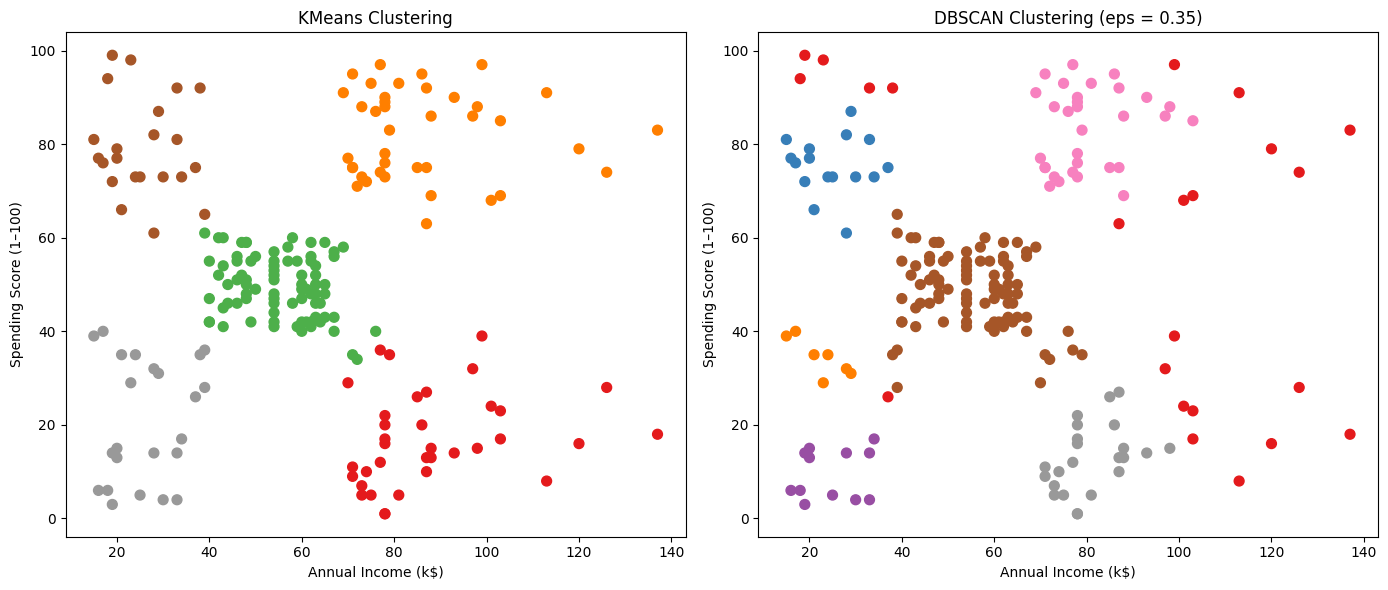

In [55]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Fit KMeans
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# KMeans
axes[0].scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='Set1', s=50)
axes[0].set_title("KMeans Clustering")
axes[0].set_xlabel("Annual Income (k$)")
axes[0].set_ylabel("Spending Score (1–100)")

# DBSCAN
axes[1].scatter(X[:, 0], X[:, 1], c=db_labels, cmap='Set1', s=50)
axes[1].set_title("DBSCAN Clustering (eps = 0.35)")
axes[1].set_xlabel("Annual Income (k$)")
axes[1].set_ylabel("Spending Score (1–100)")

plt.tight_layout()
plt.show()


###  Clustering Comparison: KMeans vs DBSCAN

After applying both KMeans and DBSCAN to the customer segmentation data, we conclude that **KMeans provides better clustering results** for the following reasons:

####  Why KMeans is Better:
- **Clear, well-separated clusters**: KMeans formed distinct, interpretable customer groups that align with expected business segments (e.g., high income & low spenders).
- **No noise issues**: DBSCAN marked a significant number of points as noise (`-1`), which may discard potentially valuable customer data.
- **Balanced cluster sizes**: KMeans produced more evenly distributed clusters, making the analysis of each group (e.g., average spending/income) more reliable.
- **Better visual alignment**: In the scatter plot, KMeans clusters form more consistent and interpretable regions across the income-spending space.

####  DBSCAN Limitations Observed:
- Highly sensitive to `eps` parameter: Small changes in `eps` caused large shifts in results.
- Struggles with varying density: Customer data doesn't naturally form high-density blobs, leading DBSCAN to misclassify or fragment meaningful clusters.
- Too many noise points: Valuable data was ignored, reducing cluster coverage.

>  Conclusion: **KMeans is more suitable** for this dataset because customer behavior aligns better with well-separated, spherical clusters, which KMeans captures effectively.
